# Spatial Autocorrelation (Moran's I)

Spatial autocorrelation measures how close objects are in comparison with other close objects. Moran’s I can be classified as positive, negative, and with no spatial auto-correlation.


In [140]:
%matplotlib inline
from pysal.viz import splot
from splot.esda import plot_moran
import scipy
import fiona
import seaborn as sns
import pandas as pd
import pysal.lib 
from pysal.lib import weights
from pysal.explore import esda
from numpy.random import seed
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import os
import warnings
np.random.seed(123)

In [46]:
os.getcwd()

'C:\\Users\\zamanim\\Desktop\\Python Workshop'

In [47]:
#ignore warning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading and exploring the data


Data source: https://coronavirus-resources.esri.com/datasets/628578697fb24d8ea4c32fa0c5ae1843_0/explore

Data in the Google Drive: https://drive.google.com/drive/u/0/folders/1oc3EvFkevkqsKxYhBlRooa_BzcVtlDGw

In [74]:
#Load csv file
data_path = "COVID-19_Cases_US/COVID-19_Cases_US.csv"
ref = pd.read_csv(data_path, index_col="FIPS")
ref.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3272 entries, 1001.0 to 56045.0
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    3204 non-null   float64
 1   Y                    3204 non-null   float64
 2   OBJECTID             3272 non-null   int64  
 3   Province_State       3272 non-null   object 
 4   Country_Region       3272 non-null   object 
 5   Last_Update          3272 non-null   object 
 6   Lat                  3204 non-null   float64
 7   Long_                3204 non-null   float64
 8   Confirmed            3272 non-null   int64  
 9   Recovered            0 non-null      float64
 10  Deaths               3272 non-null   int64  
 11  Active               0 non-null      float64
 12  Admin2               3272 non-null   object 
 13  Combined_Key         3272 non-null   object 
 14  Incident_Rate        3204 non-null   float64
 15  People_Tested        0 non-n

In [77]:
##Load the shapefile in geopandas
df=gpd.read_file("COVID-19_Cases_US/COVID-19_Cases_US.shp").set_index("Admin2")
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3272 entries, Autauga to Weston
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    3272 non-null   int64   
 1   Province_S  3272 non-null   object  
 2   Country_Re  3272 non-null   object  
 3   Last_Updat  3272 non-null   object  
 4   Lat         3204 non-null   float64 
 5   Long_       3204 non-null   float64 
 6   Confirmed   3272 non-null   int64   
 7   Recovered   0 non-null      object  
 8   Deaths      3272 non-null   int64   
 9   Active      0 non-null      object  
 10  FIPS        3262 non-null   object  
 11  Combined_K  3272 non-null   object  
 12  Incident_R  3204 non-null   float64 
 13  People_Tes  0 non-null      object  
 14  People_Hos  0 non-null      object  
 15  UID         3272 non-null   int64   
 16  ISO3        3272 non-null   object  
 17  geometry    3204 non-null   geometry
dtypes: float64(3), geometry(1), int64(4),

In [127]:
db = (
    gpd.GeoDataFrame(
        df.join(ref[["Admin2"]]), crs=df.crs
    )
    .to_crs(epsg=3857)[
        [ "OBJECTID","FIPS", "Deaths","geometry"]
    ]
    .dropna()
)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3196 entries, Abbeville to Ziebach
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  3196 non-null   int64   
 1   FIPS      3196 non-null   object  
 2   Deaths    3196 non-null   int64   
 3   geometry  3196 non-null   geometry
dtypes: geometry(1), int64(2), object(1)
memory usage: 253.9+ KB


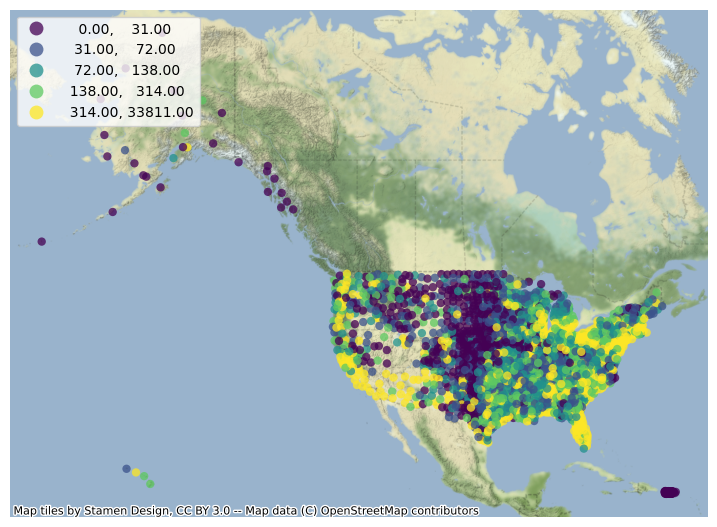

In [128]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column="Deaths",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
ctx.add_basemap(
    ax,
    crs=db.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)
ax.set_axis_off()

# Spatial weights matrix

A spatial weights matrix is the way geographical space is formally encoded into a numerical form so it is easy for a computer (or a statistical method) to understand. 

In [129]:
w_queen = weights.Queen.from_dataframe(db)

# Spatial lag

the spatial lag is a key element of many spatial analysis techniques and, as such, it is fully supported in Pysal. To compute the spatial lag of a given variable, Deaths for example, we can do it as follows:

In [136]:
db["Deaths_lag"] = weights.spatial_lag.lag_spatial(
    w_queen, db["Deaths"]
)

db["Deaths_lag"]

Abbeville     1965.0
Acadia        1662.0
Accomack       500.0
Ada           1047.0
Adair          392.0
              ...   
Yuma         28844.0
Yuma           220.0
Zapata        2005.0
Zavala         989.0
Ziebach        169.0
Name: Deaths_lag, Length: 3196, dtype: float64

In [137]:
db.loc[["Young", "Zapata"], ["Deaths", "Deaths_lag"]]

,Deaths,Deaths_lag
Young,96,275.0
Zapata,56,2005.0


# Moran Plot

The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag.

In [142]:
db["Deaths_std"] = db["Deaths"] - db["Deaths"].mean()
db["Deaths_lag_std"] = (
    db["Deaths_lag"] - db["Deaths_lag"].mean()
)

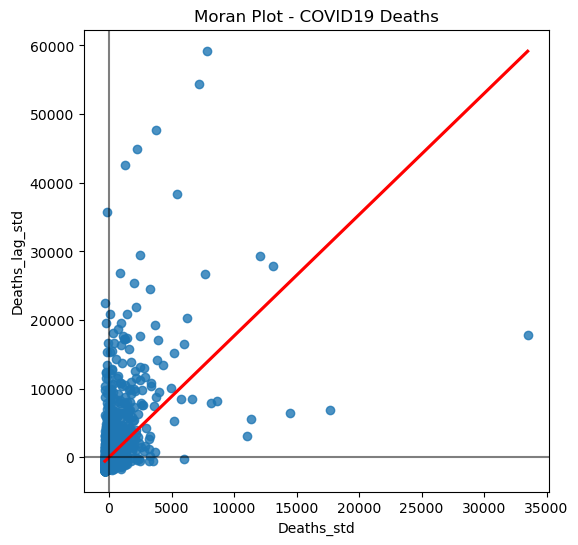

In [143]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="Deaths_std",
    y="Deaths_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - COVID19 Deaths")
plt.show()

Moran's I is a correlation coefficient that measures the overall spatial autocorrelation of your data set.  


In order to calculate Moran’s I in our dataset, we can call a specific function in esda directly:

In [144]:
w_queen.transform = "R"
moran = esda.moran.Moran(db["Deaths"], w_queen)

The method Moran creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:


In [145]:
moran.I

0.3185508335989573

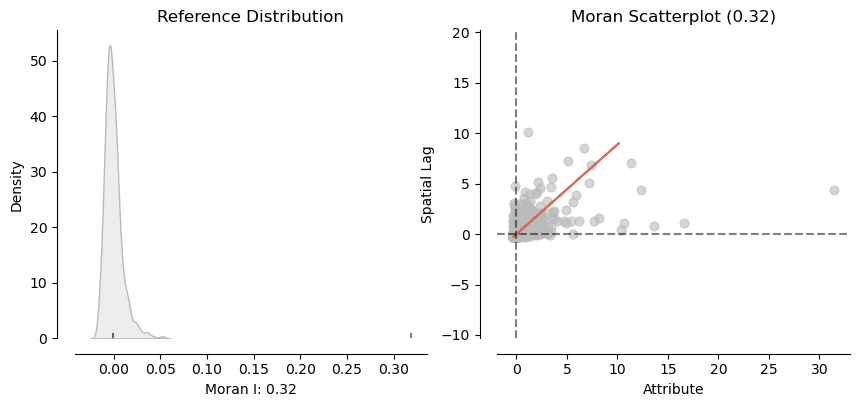

In [146]:
plot_moran(moran);